In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../cultura_1.db')
cursor = conn.cursor()
import plotly.express as px

In [2]:
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']]
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()

In [81]:
df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url'], axis=1).drop_duplicates()

df_country =  pd.read_sql_query("SELECT * FROM country_continent", conn)
df_country = df_country[['country_name', 'continent_name']]
df_country = df_country.drop_duplicates('country_name', keep='first')
df_identifiers = pd.merge(df_identifiers, df_country, on = 'country_name', how = 'left')

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51829/132721001.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = df_ind_identifiers.drop('identifier_name', axis=1)
df_ind_identifiers = pd.merge(df_ind_identifiers, df_identifiers, on = 'identifiers_wikidata_id', how = 'left')

In [100]:
df_final = pd.merge(df_individual, df_ind_identifiers, on = 'individual_wikidata_id', how = 'left')
df_final = pd.merge(df_final, df_individual_region, on = 'individual_wikidata_id')

In [113]:
test = df_final[['identifier_name', 'country_name', 'continent_name']].drop_duplicates().dropna()

In [121]:
df_final['decade'] = df_final['birthyear'].apply(lambda x : int((x+35)/10)*10)

In [137]:
df_final_region = df_final.groupby(['region_name', 'decade', 'continent_name'])['individual_wikidata_id'].count().rename('score').reset_index()
df_final_region = df_final_region[~df_final_region['continent_name'].isna()]

In [144]:
all_continents = list(set(df_final_region.continent_name))

In [310]:
def make_continent_figure(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800,  continent = ['Asia']):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig = df_fig[df_fig['continent_name'].isin(continent)]
    df_fig['score'] = df_fig.groupby('continent_name')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    
    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'continent_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Identifiers Continent')))
    fig.update_layout(xaxis=dict(dtick=100))
    fig.update_layout(xaxis_title='', yaxis_title='Normalised Score')
    
    return fig

In [311]:
df_final_region_fifty = df_final_region.copy()
df_final_region_fifty['decade'] = df_final_region_fifty['decade'].apply(lambda x: int(x/50)*50)
df_final_region_fifty = df_final_region_fifty.groupby(['region_name', 'decade', 'continent_name'])['score'].sum().reset_index()
df_final_region_fifty = df_final_region_fifty[df_final_region_fifty['continent_name']!='Africa']

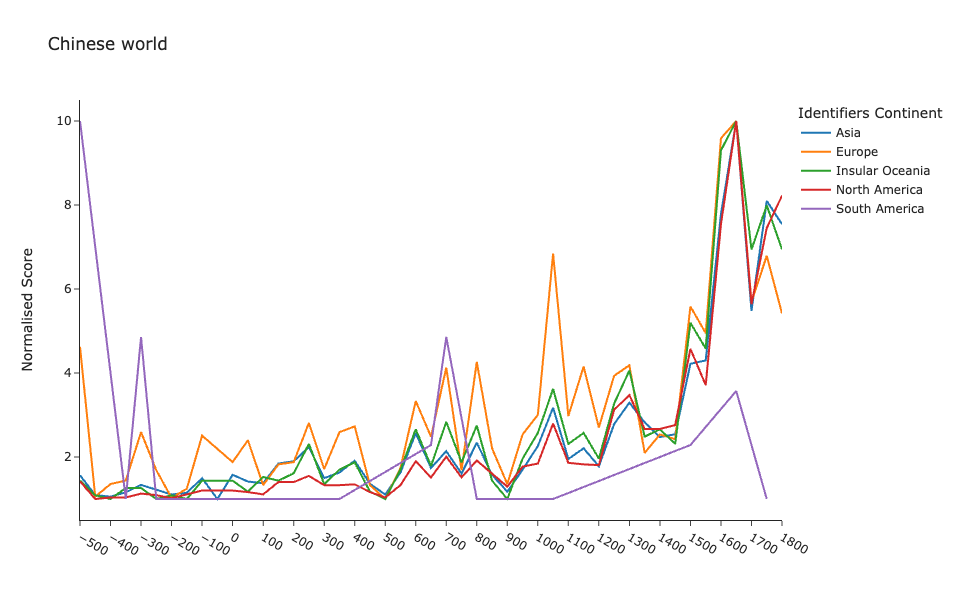

In [312]:
fig = make_continent_figure(df_final_region_fifty,region_name = 'Chinese world', min_decade = -500, max_decade = 1800,  continent = all_continents)
fig.show()

In [8]:
df_final_all = df_final.drop(['identifiers_wikidata_id', 'identifier_name'], axis=1).drop_duplicates()

In [9]:
df_final_all['identifier_name'] = 'all_identifiers'

In [11]:
df_graph_bis =  pd.concat([df_final, df_final_all])
df_graph_bis = df_graph_bis.dropna()

In [12]:
df_graph_bis['decade'] = df_graph_bis['birthyear'].apply(lambda x : int((x+35)/10)*10)
df_graph_bis = df_graph_bis.groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()

In [13]:
df_identifiers_new = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers_new = df_identifiers_new[['identifier_name', 'country_name']].copy()
df_identifiers_new['country_name'][df_identifiers_new['country_name'].isna()]=''
#df_identifiers_new = df_identifiers_new.rename(columns = {'identifier_name':'old_identifier_name'})
df_identifiers_new['identifier_name'] = df_identifiers_new.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)


In [14]:
df_graph_bis = pd.merge(df_graph_bis,df_identifiers_new, on = 'identifier_name')

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [318]:
set(df_graph_bis[df_graph_bis['country_name']=='Netherlands'].identifier_name)

{'Architectuurgids architect ID (Netherlands)',
 'BWSA ID (Netherlands)',
 'Biografisch Portaal van Nederland ID (Netherlands)',
 'Biografisch Woordenboek van Nederland: 1880-2000 ID (Netherlands)',
 'Boijmans artist ID (Netherlands)',
 'Catalogus Professorum Academiae Groninganae ID (Netherlands)',
 'Catalogus Professorum Academiae Rheno-Traiectinae ID (Netherlands)',
 'CollectieGelderland creator ID (Netherlands)',
 'DVN ID (Netherlands)',
 'Digitale Bibliotheek voor de Nederlandse Letteren author ID (Netherlands)',
 'Dutch Instrument Makers ID (Netherlands)',
 'Dutch Senate person ID (Netherlands)',
 'ECARTICO person ID (Netherlands)',
 'GTAA ID (Netherlands)',
 'HNI person/institution ID (Netherlands)',
 'IISG ID (Netherlands)',
 'Joods Biografisch Woordenboek ID (Netherlands)',
 'KNAW past member ID (Netherlands)',
 'LastDodo-area-ID (Netherlands)',
 'Leidse Hoogleraren ID (Netherlands)',
 'MovieMeter person ID (Netherlands)',
 'Muziekencyclopedie ID (Netherlands)',
 'Nationale Th

In [24]:
def make_figure(df_graph_bis, region_name, min_decade = 1200, max_decade = 1800, top_identifiers = 5):

    df_fig = df_graph_bis[df_graph_bis['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]

    one_id_country = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
    one_id_country = one_id_country.sort_values(['country_name', 'score'], ascending=(False, False))
    one_id_country = one_id_country.groupby('country_name').head(1)
    one_id_country = list(one_id_country['identifier_name'])

    df_fig = df_fig[df_fig['identifier_name'].isin(one_id_country)]
    top_ids = df_fig.groupby(['identifier_name'])['score'].sum().reset_index().sort_values('score', ascending=False)

    #top_ids = top_ids[top_ids['identifier_name']!='all_identifiers']
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    df_fig_mean = df_fig.groupby(['decade'])['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    #df_fig = pd.concat([df_fig, df_fig_mean])

    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'identifier_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white',
                  category_orders={'identifier_name': top_ids})
                 #line_shape='spline')


    #fig.update_layout(legend=dict(title=dict(text='Top 5 Immaterial Production')))
    fig.update_traces(opacity=0.25)

    fig2 = px.line(df_fig_mean, x = 'decade', y = 'score',color = 'identifier_name',
              width = 1200, 
              height = 600, 
              title = region_name, 
              template = 'simple_white')  
                   #line_shape='spline')

    fig2.update_traces(line=dict(width=3))
    fig3 = go.Figure(data=fig.data + fig2.data)
    fig3.update_layout(xaxis_title='', yaxis_title='Number of Individuals',  
                       template = 'simple_white',  
                       width = 1200, 
                       height = 600,
                      title = region_name)

# Update the layout with the category order


    #ig3.for_each_trace(lambda t: t.update(name=legend_order.index(t.name)))
    fig3.update_layout(legend=dict(title=dict(text='Identifiers')))
    #fig3.update_layout(category_orders={'Identifiers': top_ids})
    fig3.update_layout(xaxis=dict(dtick=100))

    return fig3

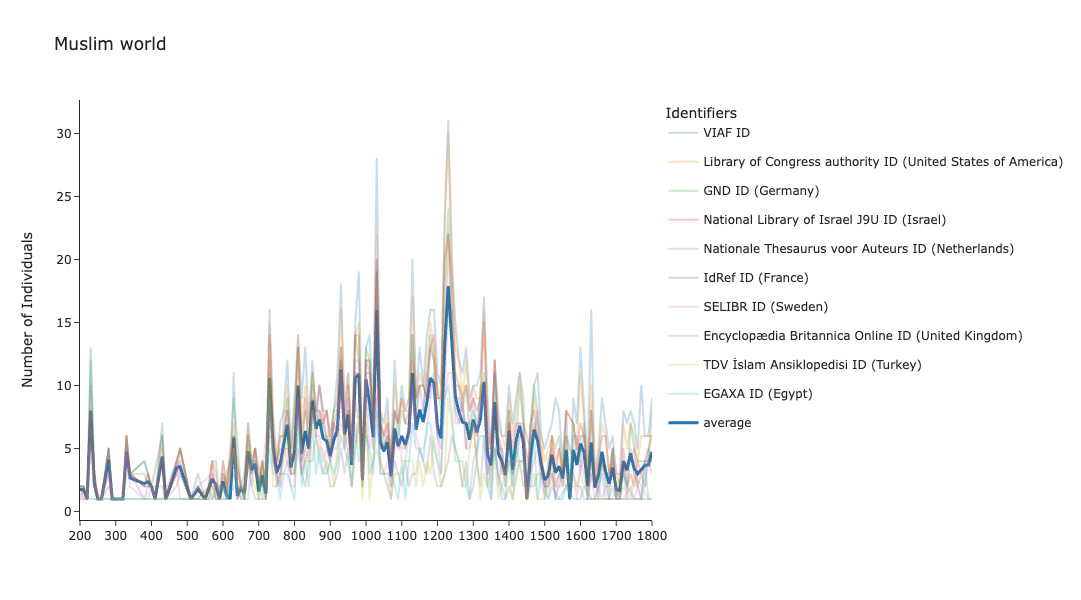

In [29]:
region_name = 'Muslim world'

fig3 = make_figure(df_graph_bis, region_name = region_name, min_decade = 200, max_decade = 1800, top_identifiers = 10)

fig3.show()
fig3.write_image(f"graph_18_05/{region_name}_identifiers.png", scale=7)

In [207]:
#for region_name in list(set(df_graph_bis['region_name']))[:10]:


In [280]:
df_count = df_final[['decade', 'region_name', 'individual_wikidata_id']].drop_duplicates()
df_count = df_count.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().rename('score').reset_index()
df_count['type'] = 'count'
df_sum = df_final.groupby(['decade', 'region_name'])['identifiers_wikidata_id'].count().rename('score').reset_index()
df_sum['type'] = 'sum'
df_graph = pd.concat([df_count, df_sum])
#df_count['decade'] = df_count['decade'].apply(lambda x: int(x/50)*50)
#df_count = df_count.groupby(['region_name', 'decade'])['score'].sum().reset_index()

In [281]:
def make_figure_comparison(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig['score'] = df_fig.groupby('type')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    
    fig = px.line(df_fig, 
                  x = 'decade', 
                  y = 'score',
                  color = 'type',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Score Type')))
    fig.update_layout(xaxis=dict(dtick=100))
    
    return df_fig, fig

In [282]:
df_fig, fig = make_figure_comparison(df_graph, region_name = 'Chinese world', min_decade = -500, max_decade = 1800)

In [283]:
import sys
sys.path.append('../')
from functions_environment import get_population
data_path_environment = '../data_env'

df_population_decade = get_population(data_path_environment)
df_population_decade = df_population_decade.rename(columns={'year':'decade'})

In [284]:
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_regions = df_individual_region[['region_code', 'region_name']].drop_duplicates()

In [285]:
df_trend = pd.merge(df_count, df_regions, on = 'region_name')
df_trend = pd.merge(df_trend, df_population_decade, on =['region_code', 'decade'])
df_trend['score_capita'] = df_trend['score']/df_trend['population']


In [332]:
#set(df_count.region_name)

In [ ]:
# russian world?

In [325]:
set(df_trend.region_name)

{'Arabic world',
 'Austria',
 'Balkans',
 'Belgium',
 'British Islands',
 'Central Europe',
 'Chinese world',
 'Denmark',
 'Eastern Europe',
 'France',
 'German world',
 'Germany',
 'Greece',
 'Greek World',
 'Iceland',
 'Indian world',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Muslim world',
 'Netherlands',
 'Nordic countries',
 'Northwestern Europe',
 'Ottoman Turkey',
 'Persian world',
 'Portugal',
 'Southwestern Europe',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom',
 'Western Europe'}

In [322]:
df_trend.to_csv('data_to_r/df_individual_trend.csv')

In [286]:
import numpy as np

In [287]:
def make_score_per_capita(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig['score_capita'] = np.log(1 + df_fig['score_capita'])
    #df_fig['score'] = df_fig.groupby('continent_name')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    fig = px.line(df_fig, x = 'decade', y = 'score_capita',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Identifiers Continent')))
    fig.update_layout(xaxis=dict(dtick=100))
    fig.update_layout(xaxis_title='', yaxis_title='Log Score per Capita')
    
    return fig

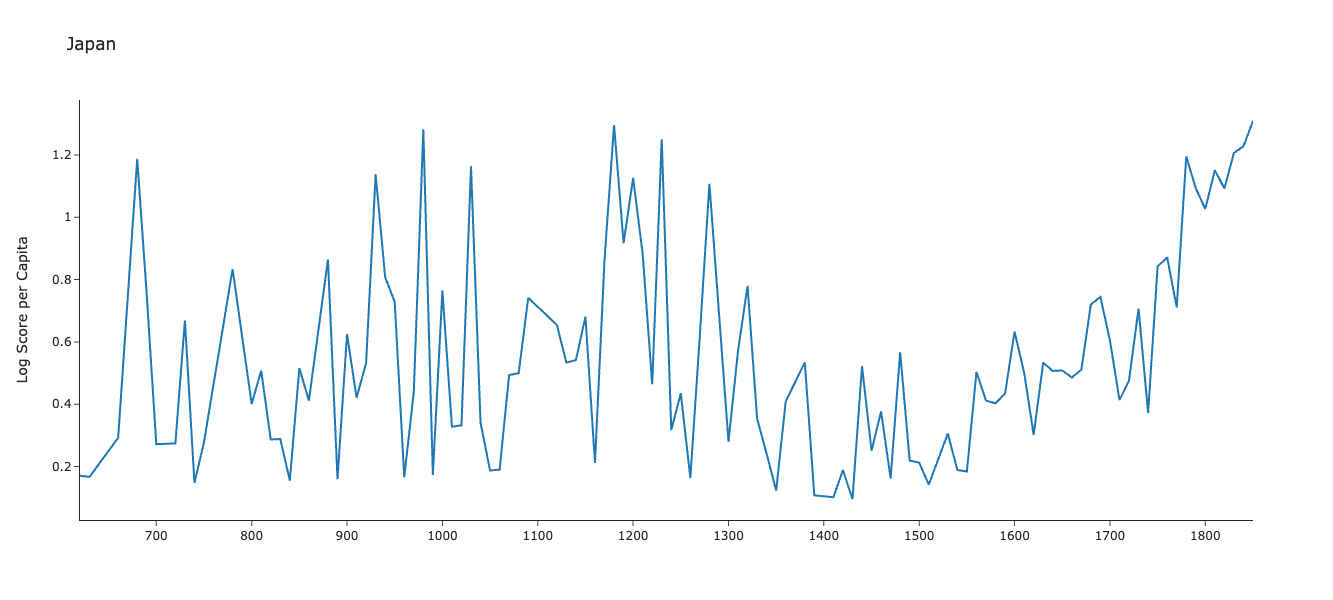

In [300]:
region_name = 'Japan'
fig = make_score_per_capita(df_trend, region_name = region_name, min_decade = -500, max_decade = 1850)
fig.show()
fig.write_image(f"graph_18_05/{region_name}_cultural_score.png", scale=7)